In [1]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

In [2]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [3]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
'''
# Load data
import pytreebank
import sys
import os

out_path = os.path.join(sys.path[0], 'data/sst_{}.txt')
dataset = pytreebank.load_sst()

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write(f"{item.to_labeled_lines()[0][0]}\t{item.to_labeled_lines()[0][1]}\n")
# Print the length of the training set
print(len(dataset['train']))
'''

'\n# Load data\nimport pytreebank\nimport sys\nimport os\n\nout_path = os.path.join(sys.path[0], \'data/sst_{}.txt\')\ndataset = pytreebank.load_sst()\n\n# Store train, dev and test in separate files\nfor category in [\'train\', \'test\', \'dev\']:\n    with open(out_path.format(category), \'w\') as outfile:\n        for item in dataset[category]:\n            outfile.write(f"{item.to_labeled_lines()[0][0]}\t{item.to_labeled_lines()[0][1]}\n")\n# Print the length of the training set\nprint(len(dataset[\'train\']))\n'

In [5]:
'''
out_path=os.path.join(sys.path[0],'phrase_data\\sst_phrase_{}.txt')
for category in ['train','test','dev']:
    with open(out_path.format(category),'w') as outfile:
        for item in dataset[category]:
            for label, sentence in item.to_labeled_lines():
                outfile.write(f"{label}\t{sentence}\n")
'''

'\nout_path=os.path.join(sys.path[0],\'phrase_data\\sst_phrase_{}.txt\')\nfor category in [\'train\',\'test\',\'dev\']:\n    with open(out_path.format(category),\'w\') as outfile:\n        for item in dataset[category]:\n            for label, sentence in item.to_labeled_lines():\n                outfile.write(f"{label}\t{sentence}\n")\n'

In [6]:
train_df=pd.read_csv('data/sst_train.txt', names=['label','text'],sep='\t')
test_df=pd.read_csv('data/sst_test.txt',names=['label','text'],sep='\t')
val_df=pd.read_csv('data/sst_dev.txt',names=['label','text'],sep='\t')

## Text Preprocessing

In [7]:
#get stopword list
sw_list=stopwords.words('english')

In [8]:
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [9]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

In [10]:
#Get nltk tag for lemmatizing a given token
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [11]:
# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)

In [12]:
def clean_texts(text):
    #remove URLs
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    #remove special characters
    text = re.sub(r"[^a-zA-Z]", ' ', text)
    #convert to lower case
    text=text.lower()
    #remove extra white spaces
    text = re.sub(r" +",' ', text)
    #lemmatization of tweet and removing stopwords
    lemmatized_text=lemmatize_sentence(text)
    #remove extra white spaces
    text = re.sub(r" +", ' ', text)
    return lemmatized_text.strip()

In [13]:
train_df['text']=[clean_texts(sentences) for sentences in train_df['text']]


In [14]:
test_df['text']=[clean_texts(sentences) for sentences in test_df['text']]
val_df['text']=[clean_texts(sentences) for sentences in val_df['text']]

In [15]:
train_df.eq('').sum()

label     0
text     11
dtype: int64

### Discarding empty rows

In [16]:
train_df.replace("",np.nan,inplace=True)
train_df.dropna(subset=['text'],inplace=True)
train_df.reset_index(drop=True,inplace=True)
train_df.eq('').sum()

label    0
text     0
dtype: int64

In [17]:
test_df.replace("",np.nan,inplace=True)
test_df.dropna(subset=['text'],inplace=True)
test_df.reset_index(drop=True,inplace=True)
test_df.eq('').sum()

label    0
text     0
dtype: int64

In [18]:
val_df.replace("",np.nan,inplace=True)
val_df.dropna(subset=['text'],inplace=True)
val_df.reset_index(drop=True,inplace=True)
val_df.eq('').sum()

label    0
text     0
dtype: int64

## TF-IDF Vectorization

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer(max_features=6000)
train_tfidf=pd.DataFrame(tfidf_vect.fit_transform(train_df['text']).toarray())
train_df=train_df.join(train_tfidf)

In [20]:
test_tfidf=pd.DataFrame(tfidf_vect.transform(test_df['text']).toarray())
test_df=test_df.join(test_tfidf)

In [21]:
val_tfidf=pd.DataFrame(tfidf_vect.transform(val_df['text']).toarray())
val_df=val_df.join(val_tfidf)

## Create dataset class

In [22]:
from torch.utils.data import DataLoader,Dataset
class texts_dataset(Dataset):
    def __init__(self,dataframe):
        self.tfidf=torch.tensor(dataframe.iloc[:,2:].values).float()
        self.labels=torch.tensor(dataframe.iloc[:,0].values).float()
        self.text=list(dataframe['text'])

    def __getitem__(self,i):
        return (self.tfidf[i],self.labels[i],self.text[i])

    def __len__(self):
        return len(self.labels)

In [23]:
train_data=texts_dataset(train_df)

In [24]:
val_data=texts_dataset(val_df)

In [25]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
train_df.shape

(8533, 6002)

In [28]:
INPUT_SHAPE=6000

## Define FFN model

In [29]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(in_features=INPUT_SHAPE,out_features=64)
        self.dropout=nn.Dropout(p=0.2)
        self.fc2=nn.Linear(in_features=64,out_features=32)
        self.out=nn.Linear(in_features=32,out_features=5)
    
    def forward(self,t):
        # Input layer
        t=self.fc1(t)
        t=F.relu(t)

        # Dropout layer
        t=self.dropout(t)

        # Hidden layer
        t=self.fc2(t)
        t=F.relu(t)

        # Output layer
        t=self.out(t)

        return t

In [30]:
import torch.optim as optim

In [31]:
val_features=torch.tensor(test_df.iloc[:,2:].values).float()
val_labels=torch.tensor(test_df.iloc[:,0].values).float()

In [32]:
train_loader = torch.utils.data.DataLoader(train_data
    ,batch_size=32
    ,shuffle=True
)
val_loader= torch.utils.data.DataLoader(val_data,batch_size=32)

In [33]:
prev_val_loss=np.inf

## Create model object and train

In [50]:
# Create FFN object
network=FFN()
min_val_loss=np.inf
# Define optimizer
optimizer=optim.Adam(network.parameters(),lr=0.02)
for epoch in range(20):
    total_loss=0
    total_correct=0
    epoch_val_loss=0
    val_correct=0
    network.train()
    for batch in train_loader:
        features,labels,text=batch
        preds=network(features)
        loss=F.cross_entropy(preds,labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_correct+=get_num_correct(preds,labels)
    network.eval()
    with torch.no_grad():
        for data,val_labels,val_text in val_loader:
            val_preds=network(data)
            val_loss=F.cross_entropy(val_preds,val_labels.long())
            val_correct+=get_num_correct(val_preds,val_labels)
            epoch_val_loss+=val_loss.item()

    
    print(
        "Epoch = ",epoch+1,
        "| Loss = ",total_loss,
        "| Training Accuracy = ",total_correct/len(train_data),
        f"| Val_correct = {val_correct}/{len(val_df)}",
        "| Val_loss = ",epoch_val_loss,
    )
    print("-"*150)


Epoch =  1 | Loss =  387.81315636634827 | Training Accuracy =  0.3584905660377358 | Val_correct = 445/1098 | Val_loss =  47.55988955497742
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch =  2 | Loss =  312.5702924132347 | Training Accuracy =  0.48165943982186804 | Val_correct = 425/1098 | Val_loss =  49.93042039871216
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch =  3 | Loss =  239.4446536898613 | Training Accuracy =  0.6181882104769718 | Val_correct = 392/1098 | Val_loss =  57.93867075443268
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch =  4 | Loss =  185.12125924229622 | Training Accuracy =  0.7187390132427048 | Val_correct = 399/1098 | Val_loss =  68.1024999

## Evaluate

In [51]:
network.eval()

FFN(
  (fc1): Linear(in_features=6000, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=5, bias=True)
)

In [52]:
with torch.no_grad():
    final_preds=network(torch.tensor(test_df.iloc[:,2:].values).float())

In [53]:
get_num_correct(final_preds,torch.tensor(test_df.iloc[:,0].values).float())/len(final_preds)

0.37771739130434784

In [54]:
torch.tensor(test_df.iloc[:,0].values).float()

tensor([2., 3., 4.,  ..., 4., 3., 0.])

In [61]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, f1_score

In [56]:
final_pred_labels=final_preds.argmax(dim=1)

In [57]:
print(accuracy_score(torch.tensor(test_df.iloc[:,0].values).float(),final_pred_labels))

0.37771739130434784


In [58]:
cm=confusion_matrix(torch.tensor(test_df.iloc[:,0].values).float(),final_pred_labels)
cm

array([[ 43, 164,  37,  34,   1],
       [ 61, 333, 121, 114,   4],
       [ 16, 148,  97, 117,   9],
       [  5, 108,  79, 278,  40],
       [  8,  35,  50, 223,  83]], dtype=int64)

In [59]:
import seaborn as sns

<AxesSubplot:>

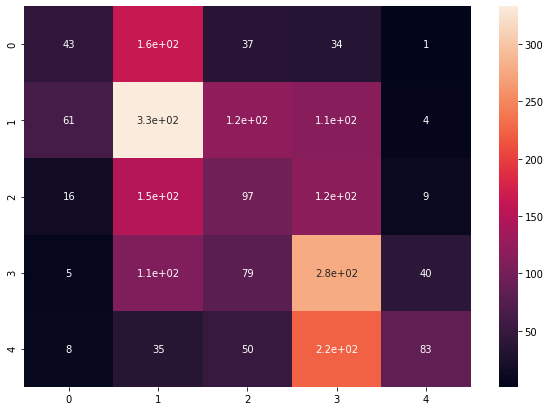

In [60]:
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot=True)

In [63]:
f1_score(torch.tensor(test_df.iloc[:,0].values).float(),final_pred_labels,average='macro')

0.33489626602835326